# Driving14x14WideRoundAbout-n2-v0 Experiment Analysis

In [1]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

algname = "POTMMCP"
baselinealgname = "I-POMCP-PF"

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, 
    "experiments", 
    "Driving14x14WideRoundAbout-n2-v0", 
    "results", 
    "experiment_results.csv"
)
baposgmcp_time_results_file = osp.join(
    BASE_REPO_DIR, 
    "experiments", 
    "Driving14x14WideRoundAbout-n2-v0", 
    "results", 
    "time_experiment_results.csv"
)
figure_dir = osp.join(BASE_REPO_DIR, "experiments", "Driving14x14WideRoundAbout-n2-v0", "figures")
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "driving14x14wideroundabout_n2_v0", "results", "klrbr_results.csv"
)

## Define Co-Player Prior

In [2]:
# Uniform
# Note K4 is not in prior 
policy_prior = {1: {
    'klr_k0_seed0-v0': 0.25,
    'klr_k1_seed0-v0': 0.25,
    'klr_k2_seed0-v0': 0.25,
    'klr_k3_seed0-v0': 0.25,
}}
coplayer_policy_ids = list(policy_prior[1])
print(coplayer_policy_ids)

['klr_k0_seed0-v0', 'klr_k1_seed0-v0', 'klr_k2_seed0-v0', 'klr_k3_seed0-v0']


# The environment 

## Problem size

- Grid size = 14 x 14
- Num free cells = (14 x 14) - 96 = 100
- Num agents = 2
- Num goal locations = 4

**States**

```
= (pos * goal)*(pos-1 * goal-1)*(direction * speed * crashed/dest_reached/none)**2
= (100*4)*(99*3)*(4*4*3)**2
= 273,715,200
~ 2.7*10**8
```

**Actions** = 5 (Do nothing, Acc, Dec, left, right)

**Observations** 

Each car observes 14 adjacent cells which can include one other vehicle, one destination

```
= pos_vehicle * pos_dest * (wall/empty)^14 cells 
= 15 * 15 * 2^14 
= 3,686,400 
~ 3.6*10**6 
```


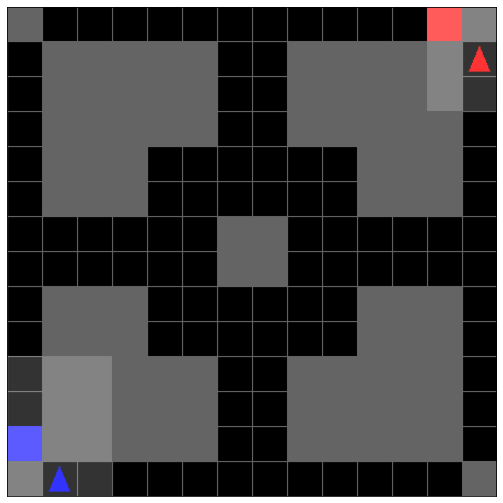

In [3]:
fig, ax = plot_utils.plot_environment("Driving14x14WideRoundAbout-n2-v0", (9, 9))
fig.savefig(osp.join(figure_dir, "env.png"))
plt.show()

## Loading Fixed Policy Data

In [4]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("All Policies")
print("------------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)
    
# Drop unneeded co-player policies
policies_to_keep = list(policy_prior[1]) + ["klr_k4_seed0-v0"]
policy_df = policy_df[policy_df["policy_id"].isin(policies_to_keep)]

fixed_policy_ids = policy_df["policy_id"].unique().tolist()
fixed_policy_ids.sort()
print("\nFixed Policies")
print("--------------")
for pi_id in fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

All Policies
------------
   klr_k0_seed0-v0
   klr_k0_seed1-v0
   klr_k0_seed2-v0
   klr_k0_seed3-v0
   klr_k0_seed4-v0
   klr_k1_seed0-v0
   klr_k1_seed1-v0
   klr_k1_seed2-v0
   klr_k1_seed3-v0
   klr_k1_seed4-v0
   klr_k2_seed0-v0
   klr_k2_seed1-v0
   klr_k2_seed2-v0
   klr_k2_seed3-v0
   klr_k2_seed4-v0
   klr_k3_seed0-v0
   klr_k3_seed1-v0
   klr_k3_seed2-v0
   klr_k3_seed3-v0
   klr_k3_seed4-v0
   klr_k4_seed0-v0
   klr_k4_seed1-v0
   klr_k4_seed2-v0
   klr_k4_seed3-v0
   klr_k4_seed4-v0
   klrbr_k4_seed0-v0
   klrbr_k4_seed1-v0
   klrbr_k4_seed2-v0
   klrbr_k4_seed3-v0
   klrbr_k4_seed4-v0
   uniform_random-v0

Fixed Policies
--------------
   klr_k0_seed0-v0
   klr_k1_seed0-v0
   klr_k2_seed0-v0
   klr_k3_seed0-v0
   klr_k4_seed0-v0

Columns
-------
   exp_id
   agent_id
   env_id
   policy_id
   exp_seed
   num_episodes
   episode_return_mean
   episode_return_std
   episode_return_max
   episode_return_min
   episode_steps_mean
   episode_steps_std
   episode_time_mean
   e

## Fixed policies pairwise performance

This is what was used to generate the meta-policies.

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


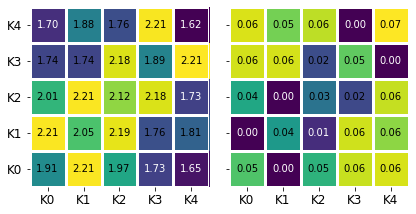

In [5]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policy_ids,
    coplayer_policies=fixed_policy_ids,
    policy_labels={
        "klr_k0_seed0-v0": "K0",
        "klr_k1_seed0-v0": "K1",
        "klr_k2_seed0-v0": "K2",
        "klr_k3_seed0-v0": "K3",
        "klr_k4_seed0-v0": "K4"
    },
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoffs.png"))

## Add Full-Knowledge Best-Response baseline

In [6]:
best_response_map = {
    "klr_k0_seed0-v0": "klr_k1_seed0-v0",
    "klr_k1_seed0-v0": "klr_k2_seed0-v0",
    "klr_k2_seed0-v0": "klr_k3_seed0-v0",
    "klr_k3_seed0-v0": "klr_k4_seed0-v0",
    # FYI K4 is added but is not used in expected results, 
    # since K4 not in other policy prior
    "klr_k4_seed0-v0": "klr_k3_seed0-v0",
}

new_rows = []
for coplayer_policy_id, br_policy_id in best_response_map.items():
    next_exp_id = policy_df["exp_id"].max() + 1
    br_row = policy_df.loc[
        # use results from agent 0 so it's the same as BA-POSGMCP and other baseline results
        (policy_df["agent_id"] == 0)
        & (policy_df["policy_id"] == br_policy_id) 
        & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
    ].copy()
    br_coplayer_row = policy_df.loc[
        (policy_df["agent_id"] == 1)
        & (policy_df["exp_id"].isin(br_row["exp_id"]))
    ].copy()
    # update policy id to baseline name
    br_row["policy_id"] = "full-knowledge-br"
    # update exp ids to avoid duplicates
    br_row["exp_id"] = next_exp_id
    br_coplayer_row["exp_id"] = next_exp_id
    new_rows.append(br_row)
    new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"] == "full-knowledge-br"]
    

10
10
220


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,episode_return_mean,episode_return_std,episode_return_max,episode_return_min,...,episode_return_CI,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,num_sims,truncated,coplayer_policy_id
210,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.20970,0.069720,2.3,2.1,...,0.004321,0.116152,0.038302,0.000,0.0,1.000,0.0,0,False,klr_k0_seed0-v0
212,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21225,0.070869,2.3,2.1,...,0.004393,0.217854,0.036358,0.000,0.0,1.000,0.0,0,False,klr_k1_seed0-v0
214,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.18125,0.298297,2.3,-0.6,...,0.018489,0.133130,0.039960,0.011,0.0,0.989,0.0,0,False,klr_k2_seed0-v0
216,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21325,0.068498,2.3,2.1,...,0.004246,0.102640,0.043274,0.000,0.0,1.000,0.0,0,False,klr_k3_seed0-v0
218,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21435,0.069689,2.3,2.1,...,0.004319,0.104956,0.043259,0.000,0.0,1.000,0.0,0,False,klr_k4_seed0-v0


## Loading BAPOSGMCP Data

In [7]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", f'"{c}",')


Policies
--------
   baposgmcp-fixed_piklrk0seed0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_piklrk0seed0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_piklrk0seed0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_piklrk0seed0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_piklrk0seed0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_piklrk1seed0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_piklrk1seed0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_piklrk1seed0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_piklrk1seed0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_piklrk1seed0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_piklrk2seed0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_piklrk2seed0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_piklrk2seed0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_piklrk2seed0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_piklrk2seed0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_piklrk3seed0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pikl

In [9]:
baposgmcp_time_df = plot_utils.import_results(
    baposgmcp_time_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_ids = baposgmcp_time_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_time_df.columns:
    print("  ", f'"{c}",')


Policies
--------
   baposgmcp-random_searchtimelimit0.1_truncatedFalse
   baposgmcp-random_searchtimelimit10_truncatedFalse
   baposgmcp-random_searchtimelimit1_truncatedFalse
   baposgmcp-random_searchtimelimit20_truncatedFalse
   baposgmcp-random_searchtimelimit5_truncatedFalse
   baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
   klr_k0_seed0-v0
   klr_k1_seed0-v0
   klr_k2_seed0-v0
   klr_k3_seed0-v0
   metabaseline_softmax
   ucbmcp-random_searchtimelimit0.1_truncatedFalse
   ucbmcp-random_searchtimelimit10_truncatedFalse
   ucbmcp-random_searchtimelimit1_truncatedFalse
   ucbmcp-random_searchtimelimit20_truncatedFalse
   ucbmcp-random_searchtimelimit5_truncatedFalse
   ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
   ucbmcp_metasoftmax_searcht

## Combine data

In [43]:
def combine_dfs(df1, df2):
    # First need to update exp_ids of one dataframe so there are no duplicate exp_ids
    df1_max_exp_id = df1["exp_id"].max()
    if df2["exp_id"].min() <= df1_max_exp_id:
        df2["exp_id"] += df1_max_exp_id+1

    combined_df = pd.concat([df1, df2]).reset_index(drop = True)

    def add_alg_id(row):
        pi_id = row["policy_id"]
        if pi_id.startswith("klr"):
            return "fixed"
        tokens = pi_id.split("_")
        alg_id = "_".join([
            t for t in tokens 
            if all(
                s not in t for s in [
                    "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "piklr",
                    "searchtimelimit"
                ]
            )
        ])
        return alg_id


    def add_meta_pi(row):
        pi_id = row["policy_id"]
        for meta_pi in ["greedy", "softmax", "uniform"]:
            if meta_pi in pi_id:
                return meta_pi
        return "NA"


    combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
    combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)

    print(combined_df["action_selection"].unique())

    policy_ids = combined_df["policy_id"].unique().tolist()
    policy_ids.sort()
    print("Policies")
    print("--------")
    for pi_id in policy_ids:
        print(f'    "{pi_id}",')

    alg_ids = combined_df["alg_id"].unique().tolist()
    alg_ids.sort()
    print("\nAlg IDs")
    print("-------")
    for n in alg_ids:
        print("  ", n)

    print("\nMeta Pis:")
    print("---------")
    print(combined_df["meta_pi"].unique().tolist())

    print("\nColumns")
    print("-------")
    for c in combined_df.columns:
        print("  ", c)
        
    return combined_df

In [44]:
baposgmcp_combined_df = combine_dfs(baposgmcp_df, policy_br_df)

['pucb' nan 'ucb' 'None']
Policies
--------
    "baposgmcp-fixed_piklrk0seed0-v0_numsims1000_truncatedTrue",
    "baposgmcp-fixed_piklrk0seed0-v0_numsims100_truncatedTrue",
    "baposgmcp-fixed_piklrk0seed0-v0_numsims10_truncatedTrue",
    "baposgmcp-fixed_piklrk0seed0-v0_numsims500_truncatedTrue",
    "baposgmcp-fixed_piklrk0seed0-v0_numsims50_truncatedTrue",
    "baposgmcp-fixed_piklrk1seed0-v0_numsims1000_truncatedTrue",
    "baposgmcp-fixed_piklrk1seed0-v0_numsims100_truncatedTrue",
    "baposgmcp-fixed_piklrk1seed0-v0_numsims10_truncatedTrue",
    "baposgmcp-fixed_piklrk1seed0-v0_numsims500_truncatedTrue",
    "baposgmcp-fixed_piklrk1seed0-v0_numsims50_truncatedTrue",
    "baposgmcp-fixed_piklrk2seed0-v0_numsims1000_truncatedTrue",
    "baposgmcp-fixed_piklrk2seed0-v0_numsims100_truncatedTrue",
    "baposgmcp-fixed_piklrk2seed0-v0_numsims10_truncatedTrue",
    "baposgmcp-fixed_piklrk2seed0-v0_numsims500_truncatedTrue",
    "baposgmcp-fixed_piklrk2seed0-v0_numsims50_truncatedTrue",

In [45]:
baposgmcp_time_combined_df = combine_dfs(baposgmcp_time_df, policy_br_df)

['pucb' nan 'ucb' 'None']
Policies
--------
    "baposgmcp-random_searchtimelimit0.1_truncatedFalse",
    "baposgmcp-random_searchtimelimit10_truncatedFalse",
    "baposgmcp-random_searchtimelimit1_truncatedFalse",
    "baposgmcp-random_searchtimelimit20_truncatedFalse",
    "baposgmcp-random_searchtimelimit5_truncatedFalse",
    "baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue",
    "baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue",
    "baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue",
    "baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue",
    "baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue",
    "full-knowledge-br",
    "klr_k0_seed0-v0",
    "klr_k1_seed0-v0",
    "klr_k2_seed0-v0",
    "klr_k3_seed0-v0",
    "klr_k4_seed0-v0",
    "metabaseline_softmax",
    "ucbmcp-random_searchtimelimit0.1_truncatedFalse",
    "ucbmcp-random_searchtimelimit10_truncatedFalse",
    "ucbmcp-random_searchtimelimit1_truncatedFalse",
    "ucbmcp-random_searchtimelimit20_t

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1440x5328 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

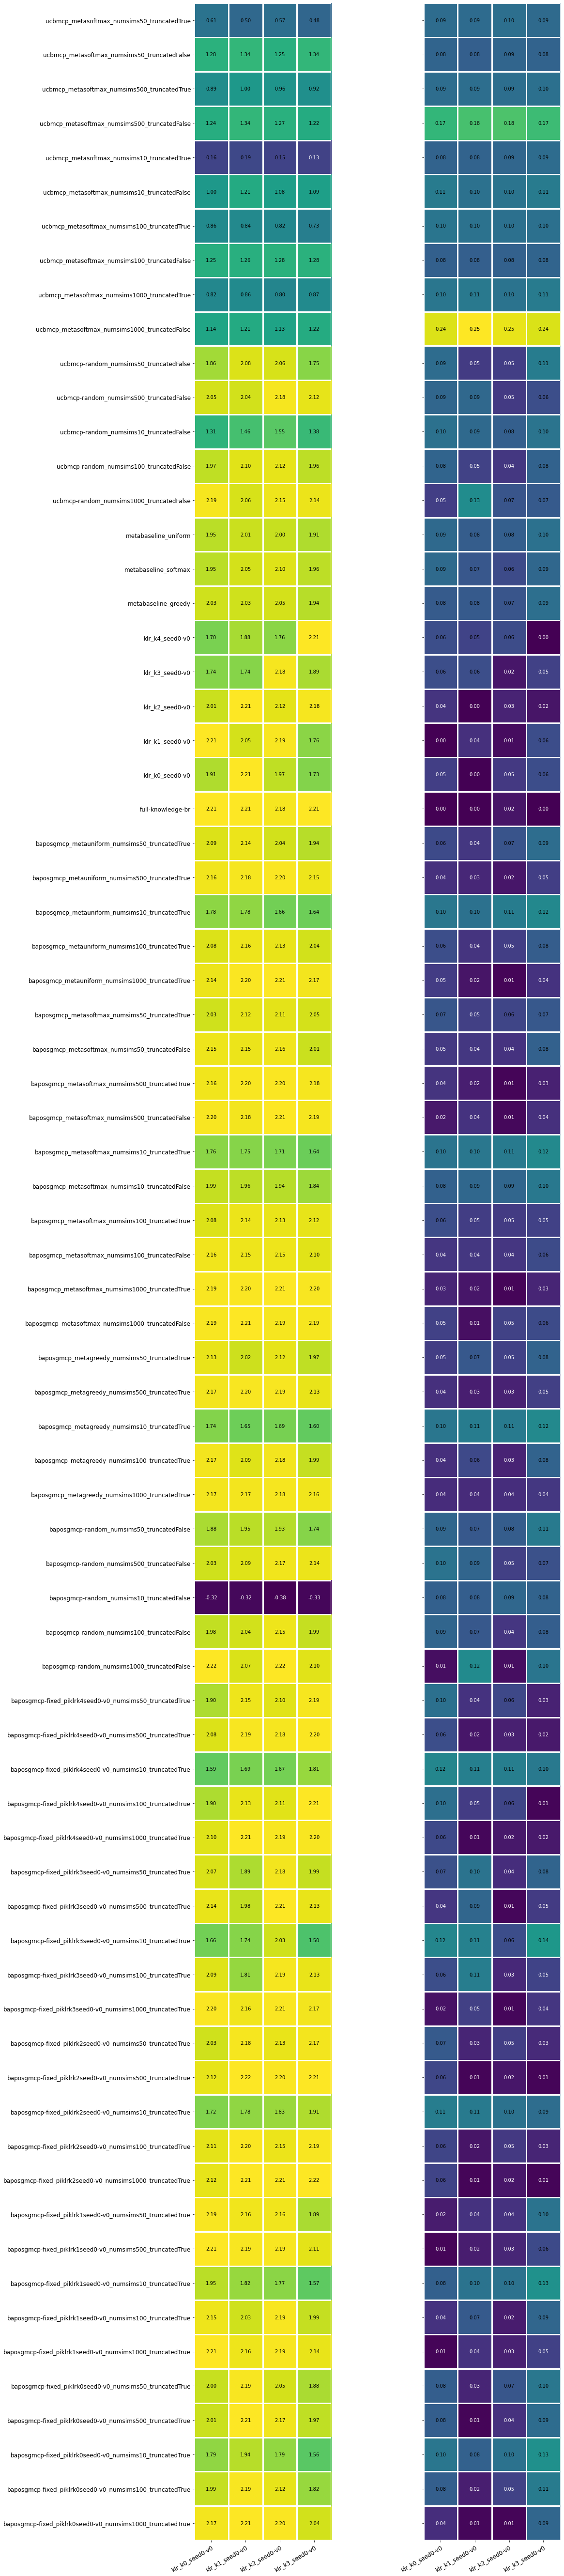

In [14]:
plot_utils.plot_pairwise_comparison(
    baposgmcp_combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(20, len(baposgmcp_combined_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1440x5328 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

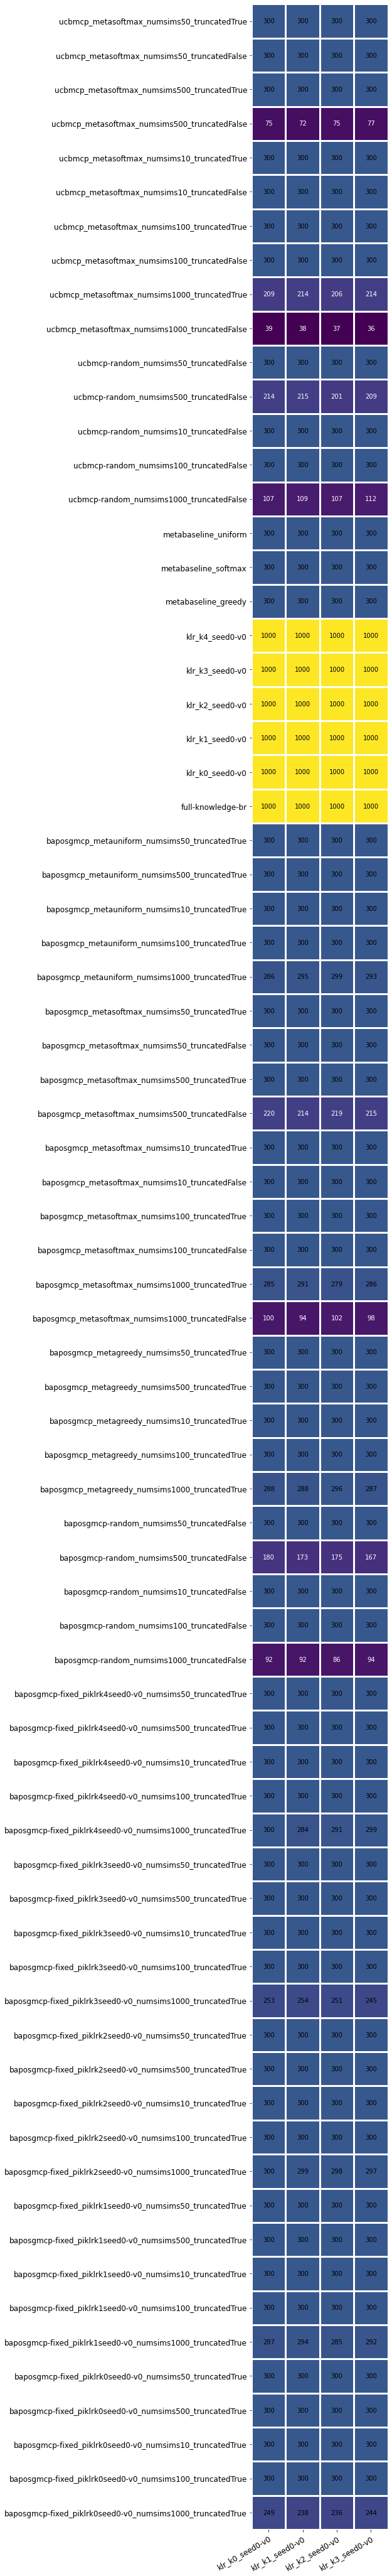

In [15]:
plot_utils.plot_pairwise_comparison(
    baposgmcp_combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, len(baposgmcp_combined_df["policy_id"].unique())), 
    valfmt="{x:.0f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

# Expected Performance

Here we look at the expected performance given the policy prior of BAPOSGMCP and the different baselines.

Specifically:

1. Comparing different meta-policies
2. Comparing different action selection strategies
3. Comparing using value function (truncated) vs rollout (untruncated) leaf node evaluation
4. Comparing performance using meta-policy vs using a single fixed policy
5. Comparing performance between all algorithms


In [46]:
exp_df = plot_utils.get_uniform_expected_df(
    baposgmcp_combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)

Ungrouped size = 320
Grouped size = 74


In [47]:
time_exp_df = plot_utils.get_uniform_expected_df(
    baposgmcp_time_combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)

Ungrouped size = 132
Grouped size = 27


In [18]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Time (s)"
})

## Comparison of the different Meta-Policies

Here we look at the performance of our algorithm using the difference meta-policies.

Looking at performance with:

- truncated search
- using PUCB

We also look at the performance of the metabaseline with the different meta-policies.

In [19]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["metabaseline"]))
        | (
            (exp_df["alg_id"].isin(["baposgmcp"])) & (exp_df["truncated"] == True)
        )
    )
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
metabaseline

Policy IDs
----------
baposgmcp_metagreedy_numsims1000_truncatedTrue
baposgmcp_metagreedy_numsims100_truncatedTrue
baposgmcp_metagreedy_numsims10_truncatedTrue
baposgmcp_metagreedy_numsims500_truncatedTrue
baposgmcp_metagreedy_numsims50_truncatedTrue
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedTrue
baposgmcp_metauniform_numsims1000_truncatedTrue
baposgmcp_metauniform_numsims100_truncatedTrue
baposgmcp_metauniform_numsims10_truncatedTrue
baposgmcp_metauniform_numsims500_truncatedTrue
baposgmcp_metauniform_numsims50_truncatedTrue
metabaseline_greedy
metabaseline_softmax
metabaseline_uniform


baposgmcp
metabaseline


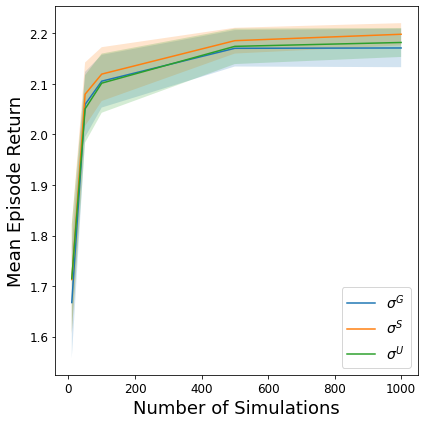

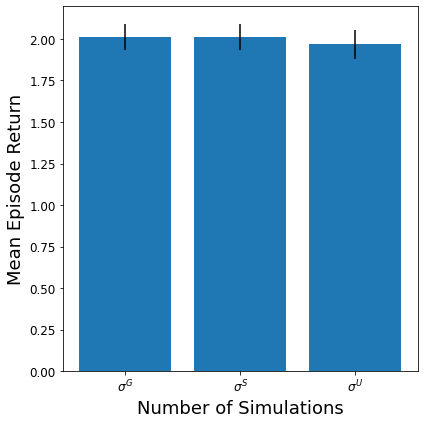

In [20]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (1.5, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Meta-Policy" 
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}.png"))
    
del plot_kwargs

## Action Selection

Compare performance between the different action selection strategies.

Specifically looking at:

- UCB vs PUCB

For truncated and rollouts (untruncated) and also using Meta vs Random search policies.

In [21]:
exp_df["action_selection"].unique()

array(['pucb', None, 'ucb'], dtype=object)

In [22]:
act_sel_label_map = {
    ("baposgmcp", "pucb"): "PUCB + Meta",
    ("baposgmcp-random", "pucb"): "PUCB + Random",
    ("ucbmcp", "ucb"): "UCB + Meta",
    ("ucbmcp-random", "ucb"): "UCB + Random",
}

act_sel_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', 'ucb']))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-random", "ucbmcp", "ucbmcp-random"]))
]

act_sel_alg_ids = act_sel_df["alg_id"].unique().tolist()
act_sel_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in act_sel_alg_ids:
    print(n)
    
policy_ids = act_sel_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-random
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_numsims1000_truncatedFalse
baposgmcp-random_numsims100_truncatedFalse
baposgmcp-random_numsims10_truncatedFalse
baposgmcp-random_numsims500_truncatedFalse
baposgmcp-random_numsims50_truncatedFalse
baposgmcp_metasoftmax_numsims1000_truncatedFalse
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedFalse
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedFalse
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedFalse
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedFalse
baposgmcp_metasoftmax_numsims50_truncatedTrue
ucbmcp-random_numsims1000_truncatedFalse
ucbmcp-random_numsims100_truncatedFalse
ucbmcp-random_numsims10_truncatedFalse
ucbmcp-random_numsims500_truncatedFalse
ucbmcp-random_numsims50_truncatedFalse
ucbmcp_metasoftmax_numsims1

In [23]:
from itertools import product

def plot_action_selection_vs_num_sims(plot_df: pd.DataFrame,
                                      ax,
                                      y_key: str,
                                      y_err_key: str,
                                      alg_id_key="alg_id",
                                      act_sel_key="action_selection",
                                      label_map=None):
    """Plot expected values for action selction strategies by num_sims."""
    if not label_map:
        label_map = {}

    alg_ids = plot_df[alg_id_key].unique().tolist()
    alg_ids.sort()

    all_act_sel = plot_df[act_sel_key].unique().tolist()
    all_act_sel.sort()

    for alg_id, act_sel in product(alg_ids, all_act_sel):
        a_df = plot_df[
            (plot_df[act_sel_key] == act_sel)
            & (plot_df[alg_id_key] == alg_id)
        ]
        if len(a_df) == 0:
            continue

        a_df = a_df.sort_values(by="num_sims")
        x = a_df["num_sims"]
        y = a_df[y_key]
        y_err = a_df[y_err_key]
    
        ax.plot(x, y, label=label_map.get((alg_id, act_sel), f"{alg_id} - {act_sel}"))
        ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)

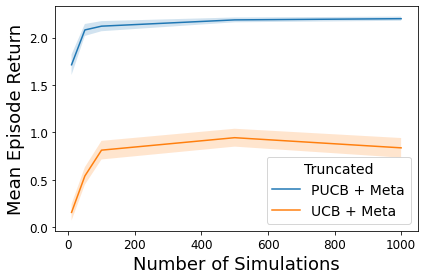

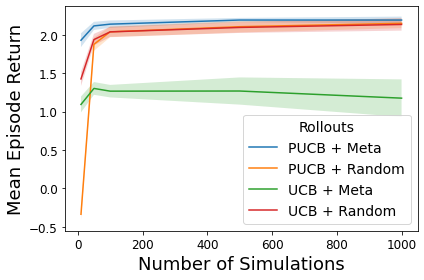

In [24]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (-0.3, 2.4),
})
plot_kwargs["legend_kwargs"].update({
    # "loc": "lower right",
    # "title": "Action Selection",  
})


for trunc in [True, False]:
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        squeeze=True,
        subplot_kw=plot_kwargs["subplot_kwargs"],
    )
    if trunc:
        plot_kwargs["legend_kwargs"]["title"] = "Truncated"
    else:
        plot_kwargs["legend_kwargs"]["title"] = "Rollouts"
    
    plot_action_selection_vs_num_sims(
        act_sel_df[
            (act_sel_df["truncated"] == trunc)
        ],
        ax=ax,
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        alg_id_key="alg_id",
        act_sel_key="action_selection",
        label_map=act_sel_label_map
    )
    ax.legend(**plot_kwargs["legend_kwargs"])
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"act_sel_return_{alg_id}_trunc{trunc}.png"))
    
del plot_kwargs

## Comparison of truncation

Here we look at the performance of BAPOSGMCP using truncated and untruncated search.

We look at the final performance as well as search time.

We only look at performance with BAPOSGMCP using PUCB and the best meta-policy.

In [25]:
exp_df["truncated"].unique()

array([ True, False])

In [26]:
truncated_label_map = {
    True: "Value Function",
    False: "Rollout"
}

trunc_df = exp_df[
    (exp_df["action_selection"].isin(['pucb']))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (exp_df["alg_id"].isin(["baposgmcp"]))
]

print("Truncated values =", trunc_df["truncated"].unique())

trunc_alg_ids = trunc_df["alg_id"].unique().tolist()
trunc_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in trunc_alg_ids:
    print(n)
    
policy_ids = trunc_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Truncated values = [False  True]
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_numsims1000_truncatedFalse
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedFalse
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedFalse
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedFalse
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedFalse
baposgmcp_metasoftmax_numsims50_truncatedTrue


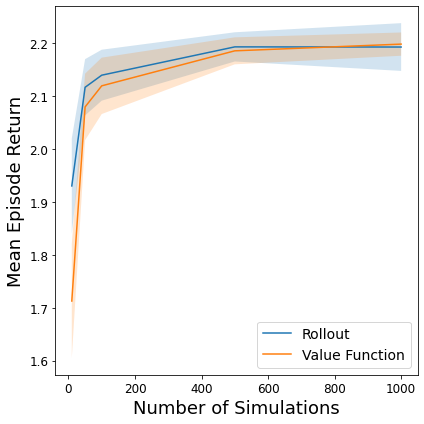

In [27]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (0, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'lower right',
    # "title": "Truncated",  
})

for alg_id in trunc_alg_ids:
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        trunc_df[trunc_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        alg_id_key="alg_id",
        set_title=False,
        truncated_label_map=truncated_label_map,
        **plot_kwargs
    )
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"truncated_returns_{alg_id}.png"))
    
del plot_kwargs

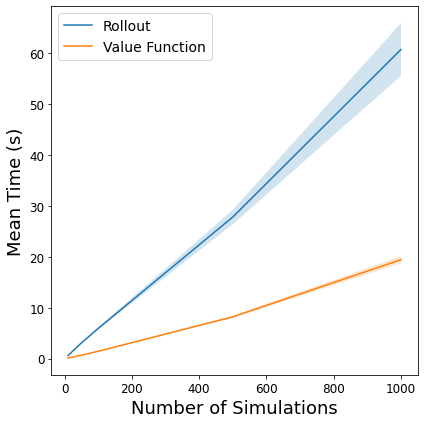

In [28]:
plot_kwargs = copy.deepcopy(time_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (0, 50),
})
plot_kwargs["legend_kwargs"].update({
    # "loc": 'upper left',
    # "title": "Truncated",  
})

for alg_id in trunc_alg_ids:
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        trunc_df[trunc_df["alg_id"] == alg_id],
        y_key="search_time_mean",
        y_err_key="search_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        truncated_label_map=truncated_label_map,
        **plot_kwargs
    )
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"truncated_search_time_{alg_id}.png"))
    
del plot_kwargs

## Comparing Meta-Policy versus no meta-policy (using a single policy)

Here we look at the performance of BAPOSGMCP with a meta-policy against not using a meta-policy (i.e. using the different fixed policies).

Parameters:

- Truncated search (except for random)
- using PUCB

In [29]:
meta_vs_no_pi_label_map = {
    "baposgmcp_metasoftmax": r"$\sigma^{S}$",
    "baposgmcp-random": "Random",
    "baposgmcp-fixed_piklrk0seed0-v0": "K0", 
    "baposgmcp-fixed_piklrk1seed0-v0": "K1", 
    "baposgmcp-fixed_piklrk2seed0-v0": "K2",
    "baposgmcp-fixed_piklrk3seed0-v0": "K3",
    "baposgmcp-fixed_piklrk4seed0-v0": "K4"
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed", "baposgmcp-random"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (
        ((exp_df["alg_id"] == "baposgmcp-random") & (exp_df["truncated"] == False))
        | ((exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed"])) & (exp_df["truncated"] == True))
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_piklrk0seed0-v0_numsims1000_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_numsims100_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_numsims10_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_numsims500_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_numsims50_truncatedTrue
baposgmcp-fixed_piklrk1seed0-v0_numsims1000_truncatedTrue
baposgmcp-fixed_piklrk1seed0-v0_numsims100_truncatedTrue
baposgmcp-fixed_piklrk1seed0-v0_numsims10_truncatedTrue
baposgmcp-fixed_piklrk1seed0-v0_numsims500_truncatedTrue
baposgmcp-fixed_piklrk1seed0-v0_numsims50_truncatedTrue
baposgmcp-fixed_piklrk2seed0-v0_numsims1000_truncatedTrue
baposgmcp-fixed_piklrk2seed0-v0_numsims100_truncatedTrue
baposgmcp-fixed_piklrk2seed0-v0_numsims10_truncatedTrue
baposgmcp-fixed_piklrk2seed0-v0_numsims500_truncatedTrue
baposgmcp-fixed_piklrk2seed0-v0_numsims50_truncatedTrue
baposgmcp-fixed_piklrk3seed0-v0_numsims1000_truncatedTrue
baposgmc

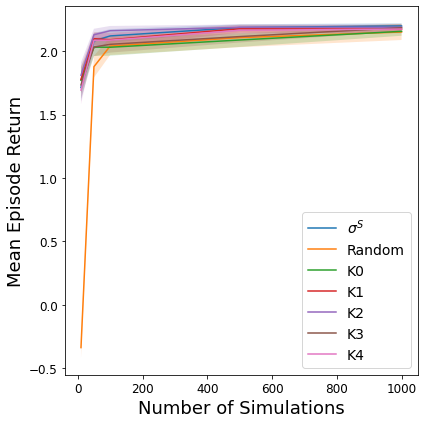

In [30]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (1.5, 2.25)
})
plot_kwargs["legend_kwargs"].update({
    # "loc": "lower right",
    # "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return.png"))
    
del plot_kwargs

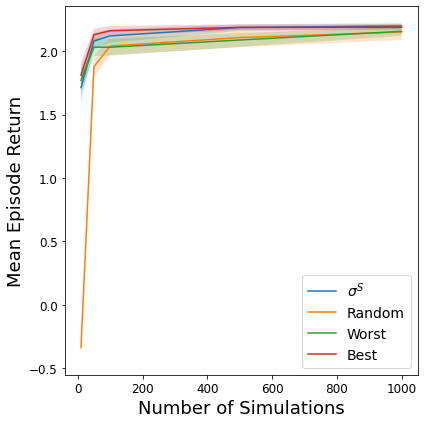

In [31]:
meta_vs_no_best_and_worst_pi_label_map = {
    "baposgmcp_metasoftmax": r"$\sigma^{S}$",
    "baposgmcp-random": "Random",
    "baposgmcp-fixed_piklrk0seed0-v0": "Worst", 
    # "baposgmcp-fixed_piklrk1seed0-v0": "K1", 
    "baposgmcp-fixed_piklrk2seed0-v0": "Best",
    # "baposgmcp-fixed_piklrk3seed0-v0": "K3",
    # "baposgmcp-fixed_piklrk4seed0-v0": "K4"
}

plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (1.5, 2.25),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_best_and_worst_pi_label_map)],
    pi_label_map=meta_vs_no_best_and_worst_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_best_and_worst.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines

Finally we compare BAPOSGMCP versus baselines. Specifically we compare:

- BAPOSGMCP (PUCB + Best Meta)
- IPOMCP-Meta (UCB + Best Meta)
- IPOMCP (UCB + Random)
- Full Knowledge BR
- Meta

In [32]:
best_meta_pi = "softmax"
perf_df = exp_df[
    (exp_df["alg_id"] == "full-knowledge-br")
    | ((exp_df["alg_id"] == "metabaseline") & (exp_df["meta_pi"] == best_meta_pi))
    | ((exp_df["alg_id"] == "baposgmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "baposgmcp-random") & (exp_df["truncated"] == False))
    | ((exp_df["alg_id"] == "ucbmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp-random") & (exp_df["truncated"] == False))
]

baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
    
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

perf_ids = perf_df["alg_id"].unique().tolist()
perf_ids.sort()
print("Alg IDs")
print("-------")
for n in perf_ids:
    print(n)
    
policy_ids = perf_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-random
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_numsims1000_truncatedFalse
baposgmcp-random_numsims100_truncatedFalse
baposgmcp-random_numsims10_truncatedFalse
baposgmcp-random_numsims500_truncatedFalse
baposgmcp-random_numsims50_truncatedFalse
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedTrue
full-knowledge-br
metabaseline_softmax
ucbmcp-random_numsims1000_truncatedFalse
ucbmcp-random_numsims100_truncatedFalse
ucbmcp-random_numsims10_truncatedFalse
ucbmcp-random_numsims500_truncatedFalse
ucbmcp-random_numsims50_truncatedFalse
ucbmcp_metasoftmax_numsims1000_truncatedTrue
ucbmcp_metasoftmax_numsims100_truncatedTrue
ucbmcp_metasoftmax_numsims10_truncatedTrue
ucbmcp_metasoftmax_numsims500_truncatedTrue
ucbmcp_metasoftmax_n

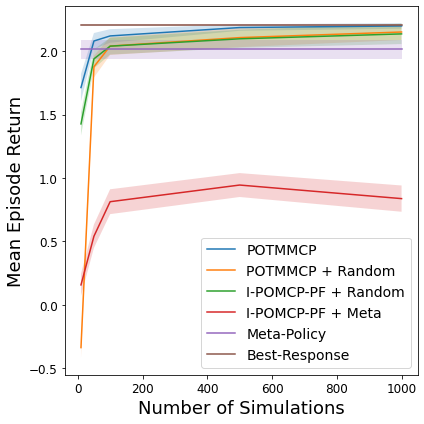

In [33]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (0.1, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    perf_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[baseline_policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "baselines_return.png"))
    
del plot_kwargs

## Performance vs search time

In [51]:
best_meta_pi = "softmax"
time_perf_df = time_exp_df[
    (time_exp_df["alg_id"] == "full-knowledge-br")
    | ((time_exp_df["alg_id"] == "metabaseline") & (time_exp_df["meta_pi"] == best_meta_pi))
    | ((time_exp_df["alg_id"] == "baposgmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "baposgmcp-random") & (time_exp_df["truncated"] == False))
    | ((time_exp_df["alg_id"] == "ucbmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "ucbmcp-random") & (time_exp_df["truncated"] == False))
]

time_baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
    
]

time_baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

time_perf_ids = time_perf_df["alg_id"].unique().tolist()
time_perf_ids.sort()
print("Alg IDs")
print("-------")
for n in time_perf_ids:
    print(n)
    
time_policy_ids = time_perf_df["policy_id"].unique().tolist()
time_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in time_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-random
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_searchtimelimit0.1_truncatedFalse
baposgmcp-random_searchtimelimit10_truncatedFalse
baposgmcp-random_searchtimelimit1_truncatedFalse
baposgmcp-random_searchtimelimit20_truncatedFalse
baposgmcp-random_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
full-knowledge-br
metabaseline_softmax
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_truncatedFalse
ucbmcp-random_searchtimelimit1_truncatedFalse
ucbmcp-random_searchtimelimit20_truncatedFalse
ucbmcp-random_searchtimelimit5_truncatedFalse
ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit10_tr

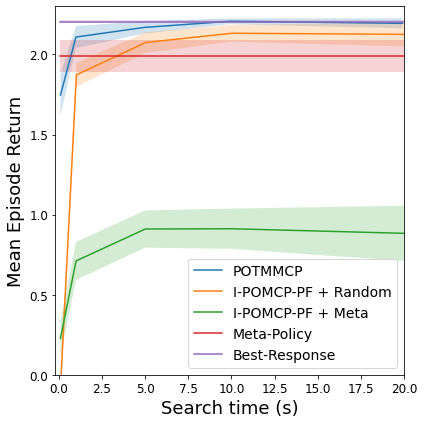

In [52]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search time (s)",
    "ylim": (0.0, 2.3),
    "xlim": (-0.2, 20)
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_search_time(
    time_perf_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[time_baseline_policy_prefixes_to_plot],
    pi_label_map=time_baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "baselines_return_vs_search_time.png"))
    
del plot_kwargs

# Analysis

Here we take a deeper dive into the characteristics of BA-POSGMCP. Specifically looking at:

1. Belief accuracy
2. Planning time

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [30]:
best_meta_pi = "softmax"
belief_df = exp_df[
    ((exp_df["alg_id"] == "baposgmcp") & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp") & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp-random") & (exp_df["truncated"] == False))
]

belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "num_sims"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in belief_group_keys:
    if k in belief_agg_dict:
        belief_agg_dict.pop(k)
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["num_sims"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))

print("\nColumns")
print("-------")
for c in belief_gb_df.columns:
    print(c)

Alg IDs
-------
baposgmcp
ucbmcp
ucbmcp-random
Ungrouped size = 25
Grouped size = 15

Columns
-------
alg_id
num_sims
exp_id
exp_seed
coplayer_policy_id
agent_id
env_id
time_limit
episode_step_limit
discount
c
c_init
c_base
truncated
action_selection
dirichlet_alpha
root_exploration_fraction
reinvigorator
known_bounds
extra_particles_prop
step_limit
epsilon
meta_policy_dict
policy_prior_map
fixed_policy_id
meta_pi
num_episodes
num_WIN
num_LOSS
num_DRAW
num_NA
action_dist_distance_0_0_n
action_dist_distance_0_1_n
action_dist_distance_0_2_n
action_dist_distance_0_3_n
action_dist_distance_0_4_n
action_dist_distance_0_5_n
action_dist_distance_0_6_n
action_dist_distance_0_7_n
action_dist_distance_0_8_n
action_dist_distance_0_9_n
action_dist_distance_0_10_n
action_dist_distance_0_11_n
action_dist_distance_0_12_n
action_dist_distance_0_13_n
action_dist_distance_0_14_n
action_dist_distance_0_15_n
action_dist_distance_0_16_n
action_dist_distance_0_17_n
action_dist_distance_0_18_n
action_dist_di

In [31]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    # "title": "Num. Sims." 
})

baposgmcp
ucbmcp
ucbmcp-random


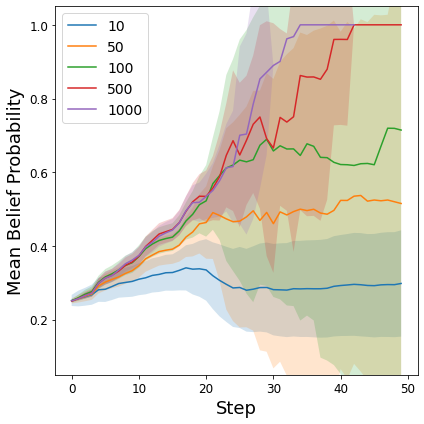

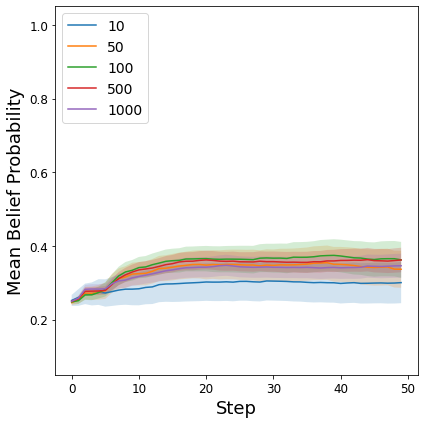

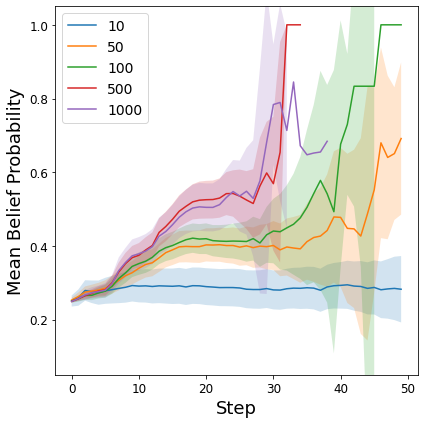

In [32]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Probability",
    "ylim": (0.05, 1.05),
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="bayes_accuracy",
        step_limit=50,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )
    
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}.png"))
    
del plot_kwargs

baposgmcp
ucbmcp
ucbmcp-random


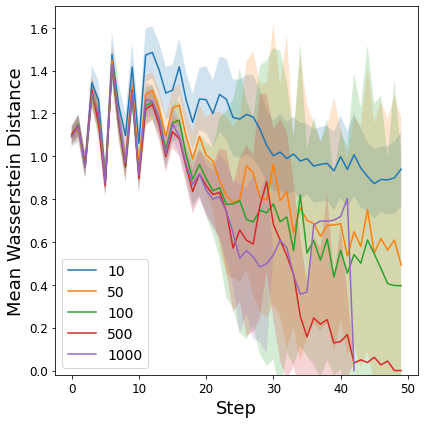

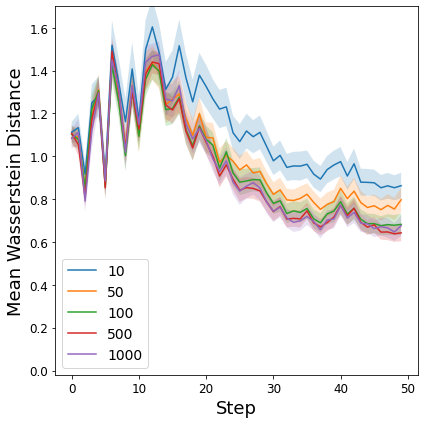

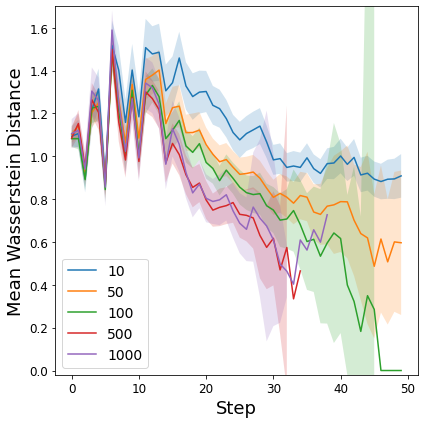

In [33]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Wasserstein Distance",
    "ylim": (-0.02, 1.7),
})

plot_kwargs["legend_kwargs"].update({
    "loc": "lower left",
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="action_dist_distance",
        step_limit=50,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )
    
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"action_dist_{alg_id}.png"))
    
del plot_kwargs

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [34]:
best_meta_pi = "softmax"
time_df = exp_df[
    ((exp_df["alg_id"] == "baposgmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp-random") & (exp_df["truncated"] == False))
]

policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}"
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}


times_alg_ids = time_df["alg_id"].unique().tolist()
times_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in times_alg_ids:
    print(n)
    
times_policy_ids = time_df["policy_id"].unique().tolist()
times_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in times_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedTrue
ucbmcp-random_numsims1000_truncatedFalse
ucbmcp-random_numsims100_truncatedFalse
ucbmcp-random_numsims10_truncatedFalse
ucbmcp-random_numsims500_truncatedFalse
ucbmcp-random_numsims50_truncatedFalse
ucbmcp_metasoftmax_numsims1000_truncatedTrue
ucbmcp_metasoftmax_numsims100_truncatedTrue
ucbmcp_metasoftmax_numsims10_truncatedTrue
ucbmcp_metasoftmax_numsims500_truncatedTrue
ucbmcp_metasoftmax_numsims50_truncatedTrue


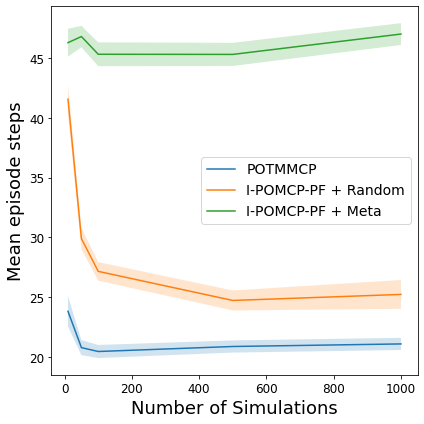

In [35]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean episode steps",
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    # "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    time_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "steps.png"))
    
del plot_kwargs

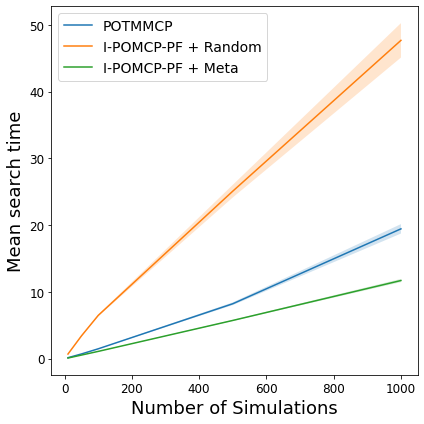

In [36]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean search time",
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    time_df,
    y_key="search_time_mean",
    y_err_key="search_time_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "search_time.png"))
    
del plot_kwargs

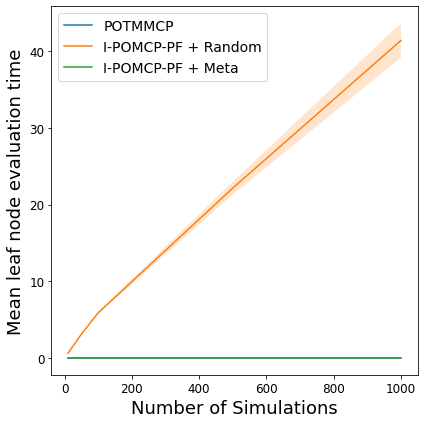

In [37]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean leaf node evaluation time",
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    time_df,
    y_key="evaluation_time_mean",
    y_err_key="evaluation_time_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "evaluation_time.png"))
    
del plot_kwargs

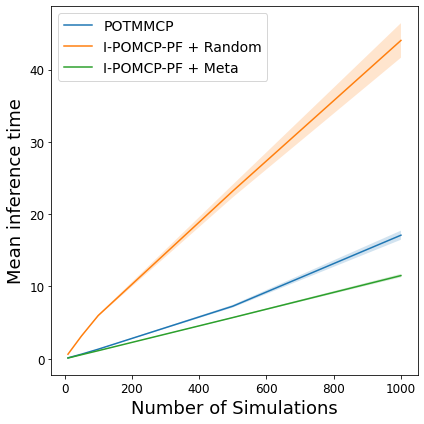

In [38]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean inference time",
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    time_df,
    y_key="inference_time_mean",
    y_err_key="inference_time_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "inference_time.png"))
    
del plot_kwargs

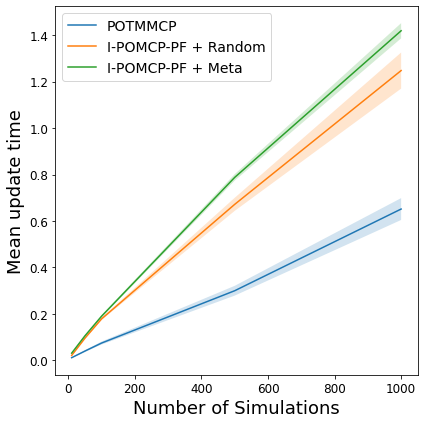

In [39]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean update time",
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    time_df,
    y_key="update_time_mean",
    y_err_key="update_time_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "update_time.png"))
    
del plot_kwargs

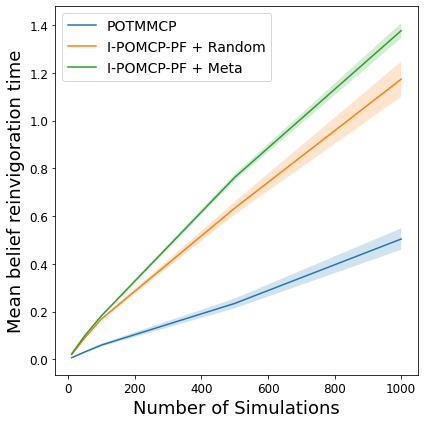

In [40]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean belief reinvigoration time",
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    time_df,
    y_key="reinvigoration_time_mean",
    y_err_key="reinvigoration_time_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "reinvigoration_time.png"))
    
del plot_kwargs

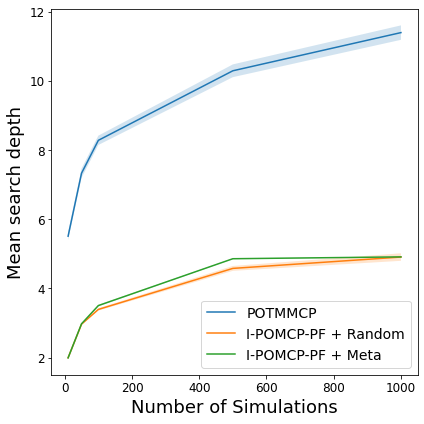

In [41]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean search depth",
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    # "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    time_df,
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "search_depth.png"))
    
del plot_kwargs